In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

PATH = 'set-lipstick-original/mask'
Copy_to_path='set-lipstick-original/'

for filename in os.listdir(PATH):
    img = Image.open(os.path.join(PATH, filename)) # images are color images
    arr = np.array(img, dtype=float)
    arr[:,:,0] *= 0.2989
    arr[:,:,1] *= 0.5870
    arr[:,:,2] *= 0.1140
    for j in range(len(arr)):
        for i in range(len(arr[j])):
            for k in range(len(arr[j][i])):

                if arr[j][i][k]>0:
                    arr[j][i][k] = 1
                else:
                    arr[j][i][k] = 0
    img = Image.fromarray(arr.astype(np.uint8))
    img.save(Copy_to_path+filename)

KeyboardInterrupt: 

In [4]:
cl = np.unique(plt.imread('set-lipstick-original/gray_mask/mask00000001.png')[:,:,0]*255)
cl

array([0., 1.], dtype=float32)

[  0 255]


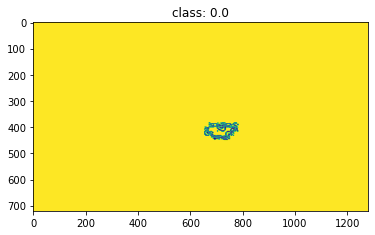

[  0 255]


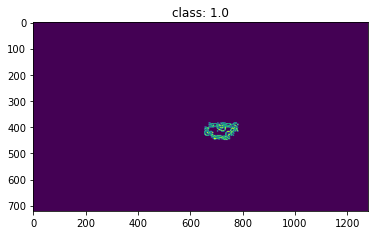

In [187]:
for i in range(len(cl)):
    mask = plt.imread('set-lipstick-original/gray_mask/mask00000001.png')*255
    mask = np.where(mask == i, 255, 0)
    mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {cl[i]}')
    plt.imshow(mask)
    plt.show()

In [5]:
photo = []
mask = []
for root, dirs, files in os.walk('set-lipstick-original'):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            photo.append(f)
        elif 'gray_mask' in f:
            mask.append(f)
        else:
            break
            
mask = sorted(mask)

In [6]:
photo_name =[]
for i in photo:
    photo_name.append(i[-12:-4])


In [7]:
mask_name =[]
for i in mask:
    mask_name.append(i[-12:-4])


In [8]:
result = list(set(photo_name)-set(mask_name))


In [9]:
photo_list = []

for i in range(len(photo)):
    
    for j in result:
        if j == photo[i][-12:-4]:
            
            photo_list.append(photo[i])
photo = sorted(list(set(photo)-set(photo_list)))


In [10]:
df = pd.DataFrame({'photo': photo, 'mask': mask})
# Отсортируем  датафрейм по значениям
df.sort_values(by='mask',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                          photo  \
0  set-lipstick-original/720p/image00000001.jpg   
1  set-lipstick-original/720p/image00000004.jpg   
2  set-lipstick-original/720p/image00000019.jpg   
3  set-lipstick-original/720p/image00000023.jpg   
4  set-lipstick-original/720p/image00000036.jpg   

                                               mask  
0  set-lipstick-original/gray_mask/mask00000001.png  
1  set-lipstick-original/gray_mask/mask00000004.png  
2  set-lipstick-original/gray_mask/mask00000019.png  
3  set-lipstick-original/gray_mask/mask00000023.png  
4  set-lipstick-original/gray_mask/mask00000036.png  


In [11]:
df.head()

,photo,mask
0,set-lipstick-original/720p/image00000001.jpg,set-lipstick-original/gray_mask/mask00000001.png
1,set-lipstick-original/720p/image00000004.jpg,set-lipstick-original/gray_mask/mask00000004.png
2,set-lipstick-original/720p/image00000019.jpg,set-lipstick-original/gray_mask/mask00000019.png
3,set-lipstick-original/720p/image00000023.jpg,set-lipstick-original/gray_mask/mask00000023.png
4,set-lipstick-original/720p/image00000036.jpg,set-lipstick-original/gray_mask/mask00000036.png


In [83]:
!pip install torch torchvision

     |████████████████████████████████| 804.1 MB 7.1 kB/s eta 0:00:015  |▏                               | 5.0 MB 1.2 MB/s eta 0:11:03     |▉                               | 20.7 MB 5.3 MB/s eta 0:02:27     |█▍                              | 34.7 MB 11.9 MB/s eta 0:01:05     |██                              | 48.1 MB 9.7 MB/s eta 0:01:18     |██▏                             | 53.8 MB 14.9 MB/s eta 0:00:51     |██▍                             | 59.2 MB 14.9 MB/s eta 0:00:51     |██▌                             | 61.6 MB 14.9 MB/s eta 0:00:50     |██▊                             | 67.9 MB 10.6 MB/s eta 0:01:10     |███                             | 73.5 MB 10.6 MB/s eta 0:01:09     |████                            | 102.1 MB 12.2 MB/s eta 0:00:58     |████▍                           | 110.6 MB 10.4 MB/s eta 0:01:07     |█████▏                          | 130.2 MB 11.6 MB/s eta 0:00:59     |█████▌                          | 137.7 MB 10.0 MB/s eta 0:01:07     |██████                        

In [12]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [13]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = Image.open(self.image_arr[index])
        img = img.resize((128,128))
        img = np.asarray(img).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        img = img.permute(2,0,1)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        #img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        lab = torch.as_tensor(lab).unsqueeze(0)
        
        
        
        
        # делаем ресайз картинки на 256х256
        # Для этого используем функцию interpolate
        ### Что бы ресайзить и высоту и ширину картинки, нужно перед interpolate
        ### пороизвести unsqueeze над тензором, и squeeze после.
        lab = lab.unsqueeze(0)
        lab = F.interpolate(input=lab, size=128, mode='nearest')
        
        lab=lab.squeeze(0).squeeze(0)
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [14]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [17]:
train_data_loader = DataLoader(train_data,batch_size=8,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=4,shuffle=False)

In [18]:
len(train_data_loader)

286

In [88]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 66 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 244 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 2.0 MB/s eta 0:00:011
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12420 sha256=e78996aa3b6e487c21e81e31b6f6501bfc8c62eaf1eb424dea8992c7908d5275
  Stored in directory: /home/rush/.cache/pip/wheels/6b/48/d7/9a3ea4072e0d735f895d5e58f9a679903dcb4e90a55418955b
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60961 sha256=709117e7fc08ada63c6b1f730bb81783641de9c5481efd9158dfc9b4b41e4996
  Stored in directory: /home/rush/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built efficientnet-pytorch pretrainedmodels


In [19]:
learning_rate = 0.02
epochs = 3

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable
    target :  NxHxW LongTensor
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    output = output.float().exp()
    target = target.type(torch.int64)
    encoded_target = output.detach() * 0
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(1, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

In [22]:
import segmentation_models_pytorch as smp
import time

# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', encoder_weights='imagenet', classes=len(cl), activation='softmax').to(device)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=segmodel.parameters(), lr=0.0001),
])

train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

max_score = 0

for i in range(0, 2):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_smp_model.pth')
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/286 [00:01<?, ?it/s]


/home/rush/anaconda3/lib/python3.8/site-packages/segmentation_models_pytorch/base/modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


RuntimeError: The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 1

In [23]:
import segmentation_models_pytorch as smp
import time

# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', classes=len(cl), activation='softmax').to(device)
optimizer = torch.optim.Adam(segmodel.parameters())
epoch_losses = []

for epoch in range(2):  # loop over the dataset multiple times
    epoch_loss = []
    time1 = time.time()
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)

        data, labels = data.to(device), labels.to(device) 
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = segmodel(data)
        loss = dice_loss(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        epoch_loss.append(loss.item())
        if batch_idx%200==0:
            print(f'batch index : {batch_idx} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    
    epoch_losses.append(epoch_loss)

batch index : 0 | loss : 0.395366907119751
batch index : 200 | loss : 0.26230818033218384
Epoch 1, loss:  0.26794947725492757
Spend time for 1 epoch: 307.36437726020813 sec
batch index : 0 | loss : 0.259382039308548
batch index : 200 | loss : 0.26034143567085266
Epoch 2, loss:  0.2614750856911386
Spend time for 1 epoch: 265.63862776756287 sec


In [24]:
def get_orig(image):
    #image = images[0,:,:,:]
    image = image.permute(1, 2, 0)
    image = image.numpy()
    image = np.clip(image, 0, 1)
    return image

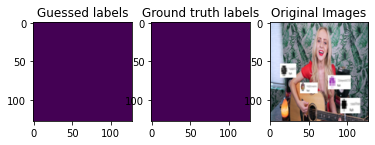

<ipython-input-105-4adcb8ae7e05>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

IndexError: index 4 is out of bounds for axis 0 with size 4

<Figure size 432x288 with 0 Axes>

In [105]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = segmodel(images)
    f, axarr = plt.subplots(1,3)

    for j in range(0,5):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,:,:])
        axarr[0].set_title('Guessed labels')

        axarr[1].imshow(labels.detach().cpu().numpy()[j,:,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
        plt.gcf().show()
        if i>5:
            break

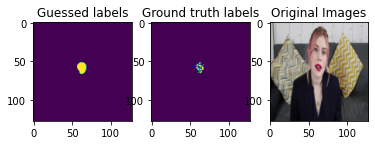

<ipython-input-33-9ef6f8f9f764>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.gcf().show()


<Figure size 432x288 with 0 Axes>

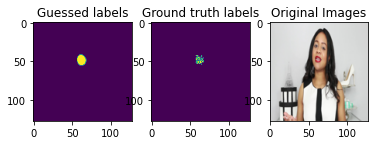

<Figure size 432x288 with 0 Axes>

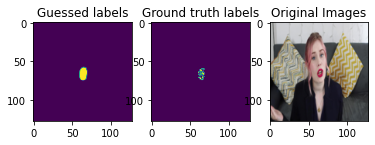

<Figure size 432x288 with 0 Axes>

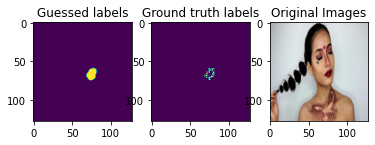

<Figure size 432x288 with 0 Axes>

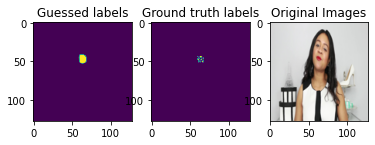

<Figure size 432x288 with 0 Axes>

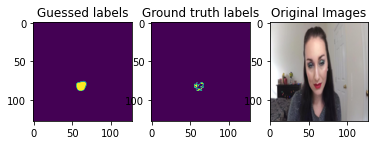

<Figure size 432x288 with 0 Axes>

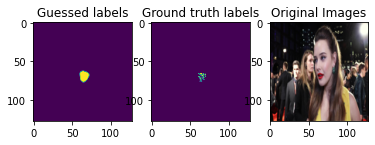

TypeError: No loop matching the specified signature and casting was found for ufunc true_divide

<Figure size 432x288 with 0 Axes>

In [33]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = segmodel(images)
    f, axarr = plt.subplots(1,3)

    for j in range(0,1):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,1,:,:])
        axarr[0].set_title('Guessed labels')

        axarr[1].imshow(labels.detach().cpu().numpy()[j,:,:])
        axarr[1].set_title('Ground truth labels')

        original = get_orig(images[j].cpu())
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
        plt.gcf().show()
        if i>1:
            break